In [4]:
from tabulate import tabulate
import pandas as pd, csv, sqlite3
conn = sqlite3.connect('mra.db')
c = conn.cursor()

In [2]:
#parse csv's
accounts = pd.read_csv('accounts.csv', sep = ',', header=0)
accounts.to_sql('accounts', conn, if_exists='replace', index = False)
click_upgrade = pd.read_csv('click_upgrade.csv', sep = ',', header=0)
click_upgrade.to_sql('click_upgrade', conn, if_exists='replace', index = False)
clicked_locked_feature = pd.read_csv('clicked_locked_feature.csv', sep = ',', header=0)
clicked_locked_feature.to_sql('clicked_locked_feature', conn, if_exists='replace', index = False)
show_inapp_pricing = pd.read_csv('show_inapp_pricing.csv', sep = ',', header=0)
show_inapp_pricing.to_sql('show_inapp_pricing', conn, if_exists='replace', index = False)
viewed_payment_details = pd.read_csv('viewed_payment_details.csv', sep = ',', header=0)
viewed_payment_details.to_sql('viewed_payment_details', conn, if_exists='replace', index = False)
subscription_created = pd.read_csv('subscription_created.csv', sep = ',', header=0)
subscription_created.to_sql('subscription_created', conn, if_exists='replace', index = False)

In [5]:
#check pandas tables and type detection from DDLs
df = pd.read_sql("""select *
from sqlite_master""", conn)
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+----+--------+------------------------+------------------------+------------+-----------------------------------------+
|    | type   | name                   | tbl_name               |   rootpage | sql                                     |
|----+--------+------------------------+------------------------+------------+-----------------------------------------|
|  0 | table  | accounts               | accounts               |          2 | CREATE TABLE "accounts" (               |
|    |        |                        |                        |            | "account_id" INTEGER,                   |
|    |        |                        |                        |            |   "created_at" TEXT,                    |
|    |        |                        |                        |            |   "creator_id" INTEGER,                 |
|    |        |                        |                        |            |   "members" INTEGER,                    |
|    |        |                 

In [7]:
#hacky workaround to handle timestamp with timezone in sqlite
pd.read_sql("""SELECT date(replace(time, ' UTC', '')) as date_day, 
time, user_id 
FROM subscription_created limit 2""", conn)

,date_day,time,user_id
0,2019-02-14,2019-02-14 15:03:29 UTC,3074457346455127815
1,2019-02-08,2019-02-08 12:48:46 UTC,3074457346439303468
2,2019-02-07,2019-02-07 03:10:32 UTC,3074457346437894997
3,2019-04-01,2019-04-01 12:47:04 UTC,3074457346454749213
4,2019-04-25,2019-04-25 08:54:13 UTC,3074457346440595468


In [83]:
#Slide 1

#checking out how long it takes users to convert from creating an account 
#> to getting a paid subscription

##data error? some accounts were paid for even before they were created
pd.read_sql("""
select *
from (
SELECT 
creator_id,
status,
datetime(replace(created_at, ' UTC', '')) as a_create,
datetime(replace(first_date_mrr, ' UTC', '')) as a_paid,
julianday(replace(first_date_mrr, ' UTC', '')) - julianday(replace(created_at, ' UTC', ''))
as time_to_pay
FROM accounts
where status is not null)
where time_to_pay < 0
""", conn)

,creator_id,status,a_create,a_paid,time_to_pay
0,3074457345909571854,active,2019-02-10 06:44:28,2019-02-10 06:38:43,-0.003993
1,3074457346418774038,active,2019-02-20 14:49:49,2019-02-20 14:44:04,-0.003993
2,87516324,active,2019-02-14 19:08:22,2019-02-13 18:16:12,-1.036227
3,3074457345962810102,expired,2019-02-21 22:33:44,2019-02-21 22:33:40,-0.000046
4,3074457346315105601,expired,2019-02-19 10:51:41,2019-02-19 10:51:38,-0.000035
5,3074457346409260371,active,2019-02-28 17:18:24,2019-02-26 22:54:35,-1.766539
6,3074457346101775739,active,2019-02-14 18:02:03,2019-02-14 17:57:35,-0.003102
7,3074457345863477252,active,2019-02-21 10:54:42,2019-02-21 10:49:39,-0.003507
8,3074457346463235200,active,2019-02-19 14:53:51,2019-02-19 12:09:39,-0.114028
9,3074457346058817184,expired,2019-02-14 04:25:54,2019-02-14 04:03:53,-0.015289


In [86]:
#find average user time taken to convert to paid from account creation
pd.read_sql("""
SELECT 
avg(julianday(replace(first_date_mrr, ' UTC', '')) - julianday(replace(created_at, ' UTC', '')))
as time_to_pay_avg
FROM accounts
where status is not null
""", conn)

,time_to_pay_avg
0,30.430774


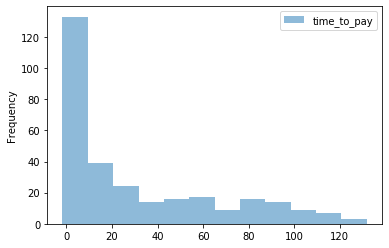

In [85]:
#find user time to account creation and check distribution
df = pd.read_sql("""
SELECT 
julianday(replace(first_date_mrr, ' UTC', '')) - julianday(replace(created_at, ' UTC', ''))
as time_to_pay
FROM accounts
where status is not null
""", conn)
ax = df.plot.hist(bins=12, alpha=0.5)

In [60]:
#Slide 2

#Build funnel to track users through story points (overall conversion - no prompts)
#accounts > upgrade click > view pricing > payment details > complete sub
pd.read_sql("""
select
count(distinct creator_id) as all_users,
count(distinct cu.user_id) as clicked_upgrade,
count(distinct sp.user_id) as viewed_pricing,
count(distinct vd.user_id) as payment_details,
count(distinct sc.user_id) as subscribers,
count(distinct case when status is not null then account_id end) as subscribing_teams

from accounts a 
left join click_upgrade cu 
    on cu.user_id = creator_id
left join show_inapp_pricing sp    
    on sp.user_id = creator_id
left join viewed_payment_details vd 
    on vd.user_id = creator_id
left join subscription_created sc
    on a.creator_id = sc.user_id 
""", conn)

,all_users,clicked_upgrade,viewed_pricing,payment_details,subscribers,subscribing_teams
0,50130,6724,6385,1258,301,301


In [59]:
#Slide 3 - initial data exploration
# check out most popular subscription touchpoints and prompts
df =  pd.read_sql("""
select 
locked_feature_name,
(sum(ct) OVER(partition by locked_feature_name)) * 1.0/ total as locked_feature_perc,
click_upgrade_from,
ct as clicks,
(ct * 1.0 /total) as ratio_to_report
from (
select
locked_feature_name,
click_upgrade_from,
count(*) as ct,
sum(count(*)) OVER() AS total
from accounts a
left join clicked_locked_feature cl
    on cl.user_id = creator_id
left join click_upgrade cu 
    on cu.user_id = creator_id
where status is not null
group by 1, 2)
order by 1, 3 desc, 2
""", conn)
#df.to_clipboard(sep=',')
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+-----+------------------------------+-----------------------+--------------------------------+----------+-------------------+
|     | locked_feature_name          |   locked_feature_perc | click_upgrade_from             |   clicks |   ratio_to_report |
|-----+------------------------------+-----------------------+--------------------------------+----------+-------------------|
|   0 |                              |             0.0284453 | team_paused_banner_dashboard   |        7 |       0.00114435  |
|   1 |                              |             0.0284453 | sharing_dialog                 |        2 |       0.000326958 |
|   2 |                              |             0.0284453 | shareable_link                 |        3 |       0.000490436 |
|   3 |                              |             0.0284453 | hi_res_export                  |       41 |       0.00670263  |
|   4 |                              |             0.0284453 | dashboard_toolbar              |       80 |     

In [88]:
#Slide 3

#find most popular sources for upgrade clicks

df = pd.read_sql("""
select
click_upgrade_from,
Count(*) as ct
from click_upgrade
group by 1
""", conn)
df.to_clipboard(sep=',')
print(df)

                 click_upgrade_from    ct
0                              None    11
1           Board cannot be created    40
2                    Features_popup   766
3               Private_board_popup   628
4                      backup_board   715
5   board_locked_by_limits_exceeded     4
6                    create_project   939
7           create_teamplate_widget   143
8                   create_template   351
9             create_template_board   533
10              custom_template_tip   246
11                   dashboard menu   682
12          dashboard_invite_window    75
13                dashboard_toolbar  4528
14                    hi_res_export  1097
15                       jira_addon    78
16         over_boards_limit_banner   134
17   over_boards_limit_banner_board   195
18          over_boards_limit_popup   652
19             private_board_locked    20
20          settings_non-team_users     7
21        settings_sharing_settings     5
22                   shareable_lin

In [90]:
#find most popular hit for locked feature prompts

#note: the 'high res export' feature is missing from here, even though it is a 
#button instead of a modal prompt, but it should probably be included in this table

df = pd.read_sql("""
select
locked_feature_name,
Count(*) as ct
from clicked_locked_feature
group by 1
""", conn)
df.to_clipboard(sep=',')
print(df)

            locked_feature_name     ct
0           Private_board_popup  11604
1                  backup_board   3983
2                create_project   7055
3       create_teamplate_widget   1097
4         create_template_board   2270
5      custom_template_personal   6055
6          custom_template_team   2555
7           custom_template_tip    246
8                    jira_addon    541
9  show_over_boards_limit_popup  11859


In [91]:
#get total locked feature + upgrade clicks

df = pd.read_sql("""
select
'locked_features' as n,
Count(*) as ct
from clicked_locked_feature
group by 1
union all
select
'upgrade clicks' as n,
count(*) as ct
from click_upgrade
group by 1
""", conn)
df.to_clipboard(sep=',')
print(df)

                 n     ct
0  locked_features  47265
1   upgrade clicks  12228


In [178]:
#Slide 4
#Build conversion funnel based on events (not users this time) 

#using time based joins and user/time stamps to reduce duplicate user flows
#looks like many users navigate to payment details and then go back to the pricing page

#note: null events in click_upgrade table show some tracking bug most likely 
#(probably no.js, adblock or interrupted sessions)

df = pd.read_sql("""
select

cu.click_upgrade_from,
count(distinct cu.user_id || cu.time ) as upgrade_clicks,
count(distinct sp.user_id || sp.time ) as pricing_clicks,
count(distinct vd.user_id || vd.time ) as payment_details,
count(distinct sc.user_id || sc.time ) as subscribers

from accounts a 
left join click_upgrade cu 
    on cu.user_id = creator_id
left join show_inapp_pricing sp    
    on sp.user_id = cu.user_id
    and replace(sp.time, ' UTC', '') 
        between replace(cu.time, ' UTC', '')
        and datetime(datetime(replace(cu.time, ' UTC', '')),'+10 minutes')
left join viewed_payment_details vd 
    on vd.user_id = sp.user_id
        and replace(vd.time, ' UTC', '') 
        between replace(sp.time, ' UTC', '')
        and datetime(datetime(replace(sp.time, ' UTC', '')),'+20 minutes')
left join subscription_created sc
    on vd.user_id = sc.user_id 
        and replace(sc.time, ' UTC', '') 
        between replace(vd.time, ' UTC', '')
        and datetime(datetime(replace(vd.time, ' UTC', '')),'+20 minutes')
group by 1
""", conn)
df.to_clipboard(sep=',')
print(df)

                 click_upgrade_from  upgrade_clicks  pricing_clicks  \
0                              None              11              10   
1           Board cannot be created              39               1   
2                    Features_popup             766              69   
3               Private_board_popup             619             658   
4                      backup_board             711             805   
5   board_locked_by_limits_exceeded               4               2   
6                    create_project             933             984   
7           create_teamplate_widget             139             153   
8                   create_template             351             365   
9             create_template_board             524             581   
10              custom_template_tip             246             258   
11                   dashboard menu             682             618   
12          dashboard_invite_window              74              76   
13    

In [137]:
#Other research - not used in task

#monthly user comparison - no point, all users created in 1 month
df = pd.read_sql("""
with allu as (
select 
strftime('%m', replace(created_at, ' UTC', '')) as m,
strftime('%Y', replace(created_at, ' UTC', '')) || '-' ||
strftime('%m', replace(created_at, ' UTC', '')) || '-' ||
'01' as date_month,
count(*) as new_monthly_users
from accounts
group by 1,2),

paid as (
select
strftime('%m', replace(first_date_mrr, ' UTC', '')) as m,
strftime('%Y', replace(first_date_mrr, ' UTC', '')) || '-' ||
strftime('%m', replace(first_date_mrr, ' UTC', '')) || '-' ||
'01' as date_month,
count(*) as new_upgraders 
from accounts
where status is not null
group by 1,2
)

select a.date_month,
new_upgraders,
new_monthly_users
from allu a left join paid b on a.m = b.m
""", conn)
df.to_clipboard(sep=',')
print(df)

   date_month  new_upgraders  new_monthly_users
0  2019-02-01            151              50130


In [180]:
#check if maybe team size has a correlation with likelihood to upgrade
pd.read_sql("""
select
company_size,
count(case when status is not null then 1 end) as paid_users,
count(*) as all_users,
count(case when status is not null then 1 end) * 1.00 / count(*) as rtr
from accounts
group by 1 order by 3 desc
""", conn)

,company_size,paid_users,all_users,rtr
0,None,81,20479,0.003955
1,2 - 50,110,13703,0.008027
2,1,59,10994,0.005367
3,51 - 250,17,1554,0.010940
4,251 - 500,6,727,0.008253
5,1001 - 5000,7,720,0.009722
6,501 - 1000,8,682,0.011730
7,10000 or more,6,618,0.009709
8,51 - 500,5,379,0.013193
9,5001 - 10000,2,274,0.007299
